## Not important for plotting

### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

Mounted at /content/gdrive


In [5]:
!cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/carbon_levels.py /content
!cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/past.py /content
!cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/params.py /content
!cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/future.py /content


In [6]:
import carbon_levels
import past
import params
from future import scenario

### Parameters  and conversion factors


In [7]:
ka, kd, delta_d, kH, AM, OM, M_upper, delta_a, K_1, K_2, Alk = params.ocean_params
mumix, mudeep, lambdaHat, gamma = params.temp_params
tao, beta,Cpf_moles, propCH4, propPassive, pf_init_T = params.permafrost_params
fds, fld, fls, flv, fnd, fns, fnv, frd, frs, fvd, fvs, beta_biota, q10, biota_init_T, npp_0 = params.biota_params

In [8]:
ppmtoMol = 1.77e+14 #mult by this for CO2 PPM -> Moles
molCO2toGT =  4.4e-14 #mult by this for moles CO2 -> GTC
ppmtoGT = 7.788 #mult by this for ppm to GTC
molCtoGT = 12/1e15

### Data



Getting the data in ppm for $CO_2$

In [9]:
file_loc = r"/content/gdrive/My Drive/ColabHannah/Data/WG1AR5_AIISM_Datafiles.xlsx"

# ppm_Data  = pd.read_excel(file_loc, 6, header = 7, index_col=0, usecols="A:D", skiprows=[8],skipfooter=40) #ppm
ppm_data_source  = pd.read_excel(file_loc, 6, header = 7, usecols="A:D", skiprows=[8],skipfooter=40) #ppm  NOte I didn't do an index col so I could get an array of years. 


ppm_data_source.columns = ['Year', 'CO2', 'CH4', 'N2O']

In [10]:
#linear interpolation

ppm_data = pd.DataFrame(columns=['Year', 'CO2', 'CH4', 'N2O'])

for k in ppm_data.columns:
    ppm_data[k] =  np.interp(np.arange(1750,2011), ppm_data_source.Year, ppm_data_source[k])

ppm_data = ppm_data.astype({'Year':'int'})




Getting the data in terms of ERF

In [11]:
# ERF_data  = pd.read_excel(file_loc, 8, header = 7, usecols="A:M", skipfooter=5) #ppm  NOte I didn't do an index col so I could get an array of years. 


 Carbon data

In [12]:

#global K_H K_1 K_2 delta_d delta_a AM Alk k_a k_d E_course
fname = r'/content/gdrive/My Drive/ColabHannah/Data/Global_Carbon_Budget_2021v1.0.xlsx'

carbon_df = pd.read_excel(fname, sheet_name = "Historical Budget", header = 16,
                                 names = ['Year', 'Fossil', 'LUC', 'Atm_Growth', 'Ocean_Sink', 'Land_Sink', 'Cement_Carb_Sink', 'Imbalance']);

#Dr Eikenberry's linear interp
#Do a linear interpolation from 0.2 to value at 1850 for LUC:
carbon_df.LUC.iloc[0:99] = np.interp(carbon_df.Year[0:99], [1751, 1849], [0.2, carbon_df.LUC[99]])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Past Modeling

In [13]:
init_ppm = params.ppmCO2_1750 

initC = carbon_levels.get_C_init(init_ppm)
# new_QA = 1000 * ppmtoMol
# start_ocean = np.array([new_QA, 725 * ppmtoMol, 36262 * ppmtoMol])

# print(initC * 12/ 1e15)

temp = np.array([0,0])

inits = np.concatenate((temp,initC), axis=None)

t_span=[1750,2010]
# ERF_data.head()


sol_2010, temp_track = past.solve_past(t_span, inits, ppm_data, carbon_df, True)



/content/past.py:95: RuntimeWarning: divide by zero encountered in log
  result = (npp_0 / molCtoGT) * (1 + beta_biota * ( np.log ( carbon /  params.ppmCO2_1750 )))


In [14]:
#state 2010
index_max = len(sol_2010.t) - 1
state_2010 = sol_2010.y[:,index_max] #QA not right here!!!!!

ppm_2010 = ppm_data.loc[ppm_data["Year"] == 2010].values[0][1]

molesQA = ppm_2010 / 1e6 * AM
state_2010[2] = molesQA

state_2010 * 12 / 1e15
# state_2010

array([9.72918126e-15, 2.63879141e-15, 8.24913789e+02, 7.40347498e+02,
       3.63102800e+04, 5.36945253e+02, 5.97344166e+01, 1.76711319e+03])

#### Figures

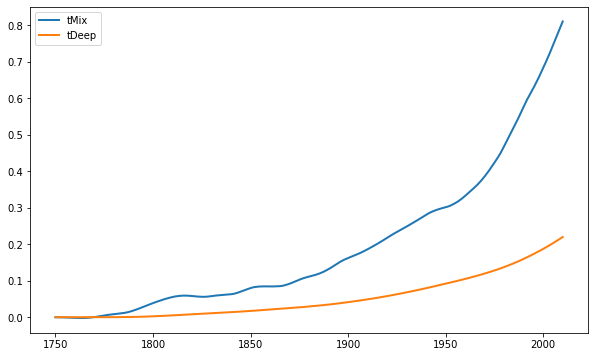

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))

ax1.plot(sol_2010.t, sol_2010.y[0,:], linewidth=2, label='tMix')
ax1.plot(sol_2010.t, sol_2010.y[1,:], linewidth=2, label='tDeep')
ax1.legend()


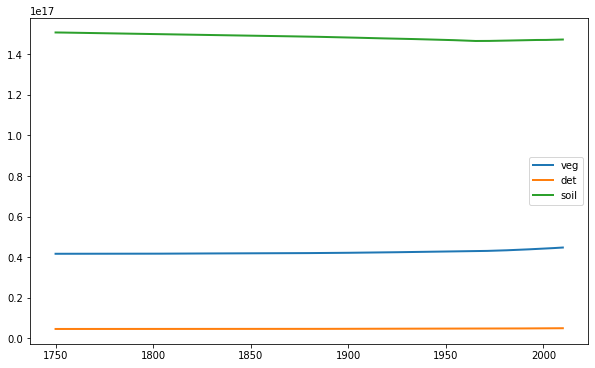

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))

ax1.plot(sol_2010.t, sol_2010.y[5,:], linewidth=2, label='veg')
ax1.plot(sol_2010.t, sol_2010.y[6,:], linewidth=2, label='det')
ax1.plot(sol_2010.t, sol_2010.y[7,:], linewidth=2, label='soil')

ax1.legend()

## Future data emissions
Starting to use emissions for future data analysis

Data and Methane Scenarios
Future RCP scenarios 

2.6, 4.5, 6, 8.5

In [17]:
# https://www.eea.europa.eu/data-and-maps/daviz/atmospheric-concentration-of-carbon-dioxide-5'
#2010 levels
ppbM = 1798
ppbN = 323.7 

tspan = [2010, 2300]
# IC_PF = np.array([7.93713150e+16, 6.20641903e+15, 1.46108124e+14 ])#  cpf, Lc, Lm Init For PF
IC_PF = np.array([Cpf_moles, 0, 0 ])#  cpf, Lc, Lm Init For PF

state = np.concatenate((state_2010, [ppbM, ppbN], IC_PF), axis = None)

In [18]:
choice = "45"
file_loc = r"/content/gdrive/My Drive/ColabHannah/Data/emissions/RCP"+choice+"_emissions.csv"
RCP_emit_df = pd.read_csv(file_loc, header = 3, usecols=[0,1,2,3,4,5], names = ["Year", "Fossil", "LUC", "CH4", "N2O", "SOx"] )

In [19]:
# tspan, state, RCP, custom_ch4(False), reduction of methane factor = .9, baseline=  140
rate = [.999, .998, .996, .995, .993, .991 , .99, .99, .98, .97, .96, .95, .94, .92, .91, .9]

temp275 = []
for x in rate:
  obj= scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, x, 275)
  temp275.append(obj.getFinalTemp())

temp250 = []
for x in rate:
  obj= scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, x, 250)
  temp250.append(obj.getFinalTemp())

temp225 = []
for x in rate:
  obj= scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, x, 225)
  temp225.append(obj.getFinalTemp())

In [20]:
temp200 = []
for x in rate:
  obj= scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, x, 200)
  temp200.append(obj.getFinalTemp())


temp175 = []
for x in rate:
  obj= scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, x, 175)
  temp175.append(obj.getFinalTemp())


In [21]:
temp150 = []
for x in rate:
  obj= scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, x, 150)
  temp150.append(obj.getFinalTemp())


temp125 = []
for x in rate:
  obj= scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, x, 125)
  temp125.append(obj.getFinalTemp())



In [22]:
obj= scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, .999, 125)


(3.65, 3.95)

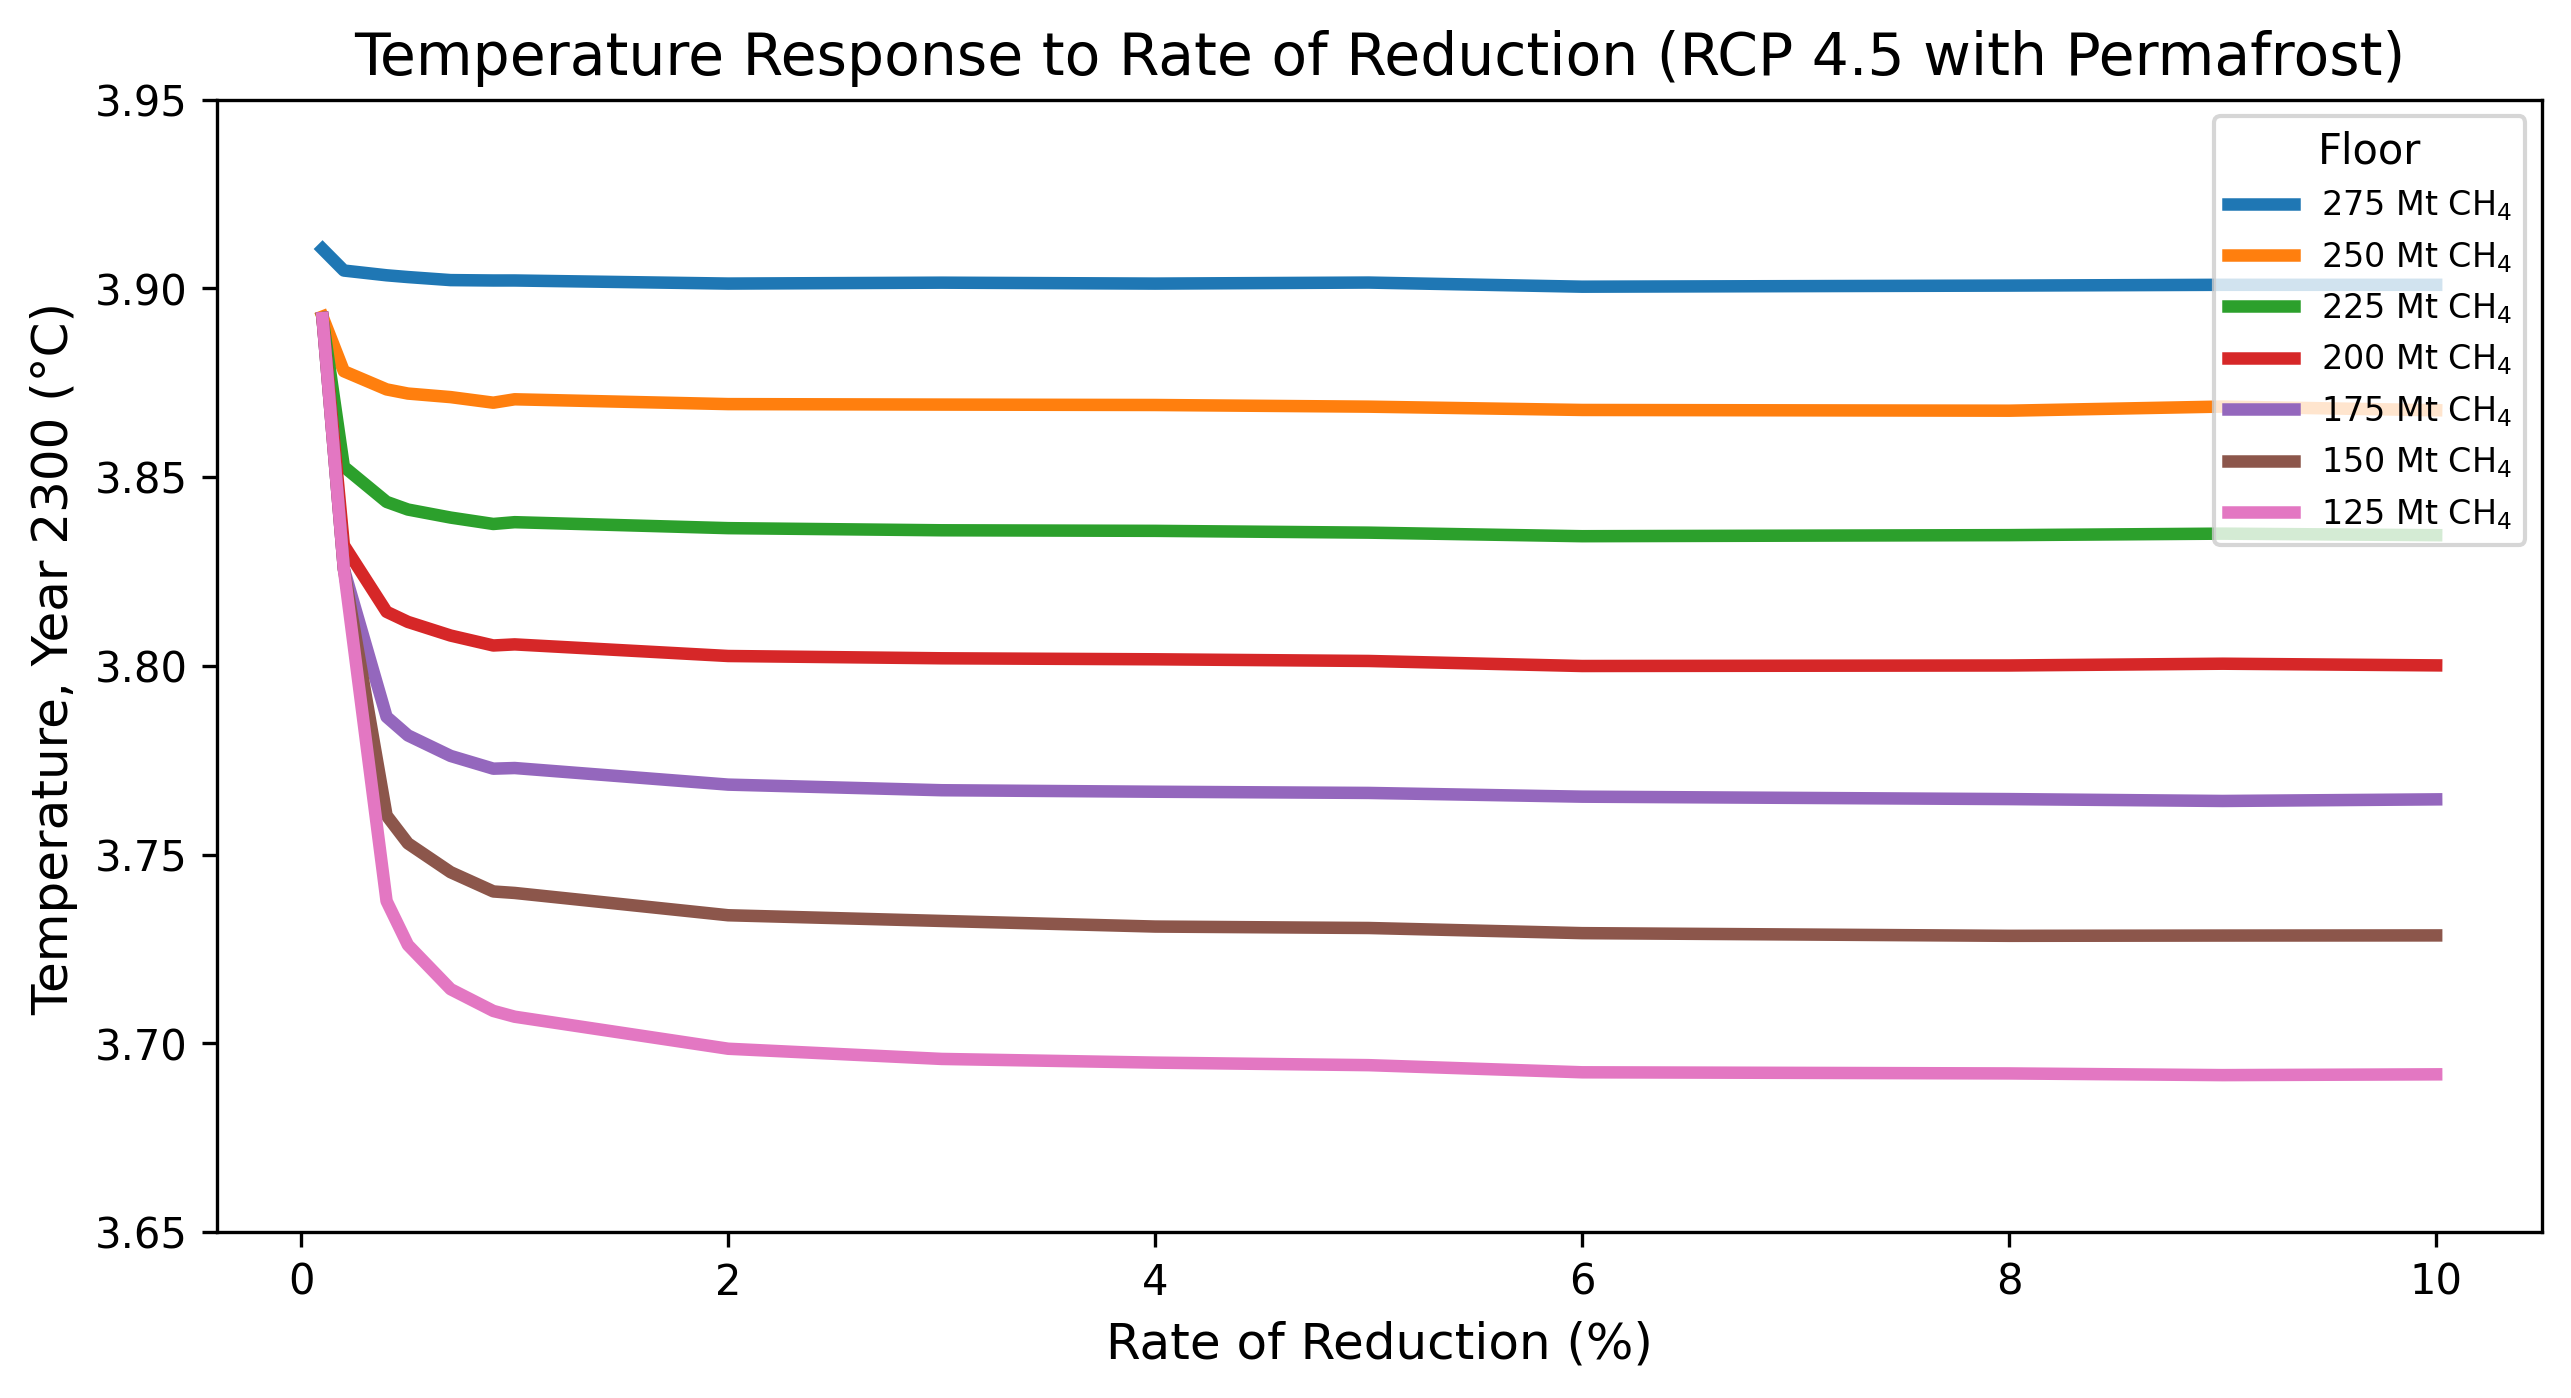

In [23]:

fig, ax = plt.subplots(1, 1, figsize = (10,5), dpi =300 )
fs = 12
rate_per = []
for x in rate:
  rate_per.append((1-x) * 100)

plt.subplots_adjust(wspace=0.25, hspace=0.25) 
lw =3
ax.plot(rate_per, temp275,linewidth=lw, label = "275 Mt CH$_4$")
ax.plot(rate_per, temp250, linewidth=lw, label = "250 Mt CH$_4$")
ax.plot(rate_per, temp225, linewidth=lw, label = "225 Mt CH$_4$")
ax.plot(rate_per, temp200, linewidth=lw, label = "200 Mt CH$_4$")
ax.plot(rate_per, temp175, linewidth=lw, label = "175 Mt CH$_4$")
ax.plot(rate_per, temp150, linewidth=lw, label = "150 Mt CH$_4$")
ax.plot(rate_per, temp125, linewidth=lw, label = "125 Mt CH$_4$")
ax.legend(loc = 'upper right', title="Floor", fontsize =8 )
# ax.legend(ncol = 7, loc = 'upper center', title="Floor",fontsize = 8)
ax.set_title("Temperature Response to Rate of Reduction (RCP 4.5 with Permafrost)", fontsize = fs+2)
ax.tick_params(axis='both', labelsize=fs-2)
ax.set_xlabel("Rate of Reduction (%)", fontsize = fs)
ax.set_ylabel(" Temperature, Year 2300 (°C)", fontsize = fs)
ax.set_ylim(3.65,3.95)


# fname = "rate_temp.png"
# plt.savefig(fname, dpi=300, facecolor="white", bbox_inches='tight', pad_inches=0.05)
# # files.download(fname)

In [24]:
# fig, ax = plt.subplots(3, 2, figsize = (11,15), dpi =300)
# fs = 12
# t0 = tspan[0]
# tf = tspan[1]
# t = np.linspace(t0, tf, tf-t0)
# scen = "2.6"
# cord = 0, 0
# ax[cord].set_ylim(-1, 18)
# ax[cord ].plot(t, obj26.getCarbonEmit()[t0:tf])
# ax[cord].set_title("Carbon emissions for RCP " + scen, fontsize = fs+2)
# ax[cord].set_ylabel("Gt of C", fontsize = fs)
# ax[cord].set_xlabel("Year", fontsize = fs)
# ax[cord].tick_params(axis='both', labelsize=fs-2)

# # ax[cord].legend()

# cord = 0,1
# ax[cord].plot(t, obj26.getMethaneEmit()[t0:tf], label = "RCP " + scen)
# ax[cord].plot(t, obj26v1.getMethaneEmit()[t0:tf], label = "RCP "+ scen +" 1% Red.", linestyle = "dashed")
# ax[cord].plot(t, obj26v10.getMethaneEmit()[t0:tf], label = "RCP "+ scen +" 10% Red.", linestyle = "dashed")
# ax[cord].set_title("CH4 emissions for RCP " + scen + " Baseline = 142 Mt CH4", fontsize = fs+2)
# ax[cord].legend()
# ax[cord].set_ylabel("Mt of CH4", fontsize = fs)
# ax[cord].set_ylim(130, 370)
# ax[cord].set_xlabel("Year", fontsize = fs)
# ax[cord].tick_params(axis='both', labelsize=fs-2)

# scen = "4.5"
# cord = 1, 0
# ax[cord].set_ylim(-1, 18)
# ax[cord].plot(t, obj45.getCarbonEmit()[t0:tf])
# ax[cord].set_ylabel("Gt of C", fontsize = fs)
# ax[cord].set_title("Carbon emissions for RCP " + scen, fontsize = fs+2)
# ax[cord].tick_params(axis='both', labelsize=fs-2)
# ax[cord].set_xlabel("Year", fontsize = fs)

# cord = 1,1
# ax[cord].plot(t, obj45.getMethaneEmit()[t0:tf],  label = "RCP " + scen)
# ax[cord].plot(t, obj45v1.getMethaneEmit()[t0:tf], label = "RCP "+ scen +" 1% Red.", linestyle = "dashed")
# ax[cord].plot(t, obj45v10.getMethaneEmit()[t0:tf], label = "RCP "+ scen +" 10% Red.", linestyle = "dashed")
# ax[cord].set_title("CH4 emissions for RCP " + scen + " Baseline = 266 Mt CH4", fontsize = fs+2)
# ax[cord].set_ylim(130, 370)
# ax[cord].set_ylabel("Mt of CH4", fontsize = fs)
# ax[cord].set_xlabel("Year", fontsize = fs)
# ax[cord].legend()
# ax[cord].tick_params(axis='both', labelsize=fs-2)


# scen = "6"
# cord = 2,0
# ax[cord].plot(t, obj6.getCarbonEmit()[t0:tf])
# ax[cord].set_ylabel("Gt of C", fontsize = fs)
# ax[cord].set_title("Carbon emissions for RCP " + scen, fontsize = fs+2)
# ax[cord].set_ylim(-1, 18)
# ax[cord].tick_params(axis='both', labelsize=fs-2)
# ax[cord].set_xlabel("Year", fontsize = fs)


# # ax[cord].legend()

# cord = 2,1
# ax[cord].plot(t, obj6.getMethaneEmit()[t0:tf], label = "RCP " + scen)
# ax[cord].plot(t, obj6v1.getMethaneEmit()[t0:tf], label = "RCP "+ scen +" 1% Red.", linestyle = "dashed")
# ax[cord].plot(t, obj6v10.getMethaneEmit()[t0:tf], label = "RCP "+ scen +" 10% Red.", linestyle = "dashed")
# ax[cord].set_title("CH4 emissions for RCP " + scen + " Baseline = 252 Mt CH4", fontsize = fs+2)
# ax[cord].set_ylim(130, 370)
# ax[cord].set_ylabel("Mt of CH4", fontsize = fs)
# ax[cord].legend()
# ax[cord].tick_params(axis='both', labelsize=fs-2)
# ax[cord].set_xlabel("Year", fontsize = fs)

# plt.subplots_adjust(wspace=0.25, hspace=0.25) 

# fname = "Emissions.png"
# plt.savefig(fname, dpi=300, facecolor="white", bbox_inches='tight', pad_inches=0.05)
# files.download(fname)

In [25]:
# scen = "4.5"

# fig, ax1 = plt.subplots(2, 1, figsize=(15,12),dpi =300)
# fs = 14
# ax1[0].plot(sol.t, sol.y[0,:],linewidth=2, label = "RCP " + scen, linestyle = "dashed")
# ax1[0].plot(sol1.t, sol1.y[0,:], linewidth=2, label = "RCP "+ scen +" 1% Red.")
# ax1[0].plot(sol2.t, sol2.y[0,:], linewidth=2, label = "RCP "+ scen + " 10% Red.")
# ax1[0].set_xlabel("Time", fontsize = fs)
# ax1[0].set_ylabel("Temp Change C°", fontsize = fs)
# ax1[0].set_title("RCP "+ scen + " without Permafrost - Methane Scenarios", fontsize = fs +2)
# ax1[0].tick_params(axis='both', labelsize=fs-2)
# ax1[0].legend()


# ax1[1].plot(solpf.t, solpf.y[0,:],linewidth=2, label = "RCP "+  scen, linestyle = "dashed")
# ax1[1].plot(sol1pf.t, sol1pf.y[0,:],linewidth=2,  label = "RCP "+ scen +" 1% Red.")
# ax1[1].plot(sol2pf.t, sol2pf.y[0,:], linewidth=2, label = "RCP "+ scen + " 10% Red.")
# ax1[1].set_xlabel("Time", fontsize = fs)
# ax1[1].set_ylabel("Temp Change C°", fontsize = fs)
# ax1[1].set_title("RCP " + scen + " with Permafrost - Methane Scenarios", fontsize = fs+2)
# ax1[1].tick_params(axis='both', labelsize=fs -2)
# ax1[1].legend()

# fname = 'RCP' +scen + 'scenario.png'
# plt.savefig(fname, dpi=300, facecolor="white", bbox_inches='tight', pad_inches=0.05)
# files.download(fname)